# Rusty Bargain

## Introduction

Rusty Bargain, a used car sales service, is in the process of developing an application designed to attract new customers. This innovative app enables users to swiftly determine the market value of their vehicle. It offers access to an extensive history including technical specifications, equipment versions, and pricing. The task at hand is to create a model that accurately determines the market value of a car. Rusty Bargain prioritizes three key aspects:

- The quality of the prediction,
- The speed of the prediction,
- The time required for training.

This initiative seeks to enhance user experience by providing immediate, accurate valuations, thereby streamlining the process of selling or purchasing used vehicles through Rusty Bargain's platform.

## Libraries

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



## Data Exploration

In [2]:
car_data = pd.read_csv('datasets/car_data.csv')
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
car_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
car_data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
car_data.duplicated().sum()

262

Just looking at this information, we can see that the dataset contains 354,369 entries and 16 columns.

There's a mix of data types, including objects (strings) and int64. The columns include information about the date the data was crawled (DateCrawled), price (Price), vehicle type (VehicleType), registration year (RegistrationYear), gearbox type (Gearbox), power (Power), model (Model), mileage (Mileage), registration month (RegistrationMonth), fuel type (FuelType), brand (Brand), whether it has been repaired (NotRepaired), the date the ad was created (DateCreated), the number of pictures (NumberOfPictures), postal code (PostalCode), and the last time it was seen online (LastSeen).

Initial Observations:

- Missing Values: Several columns have missing values (VehicleType, Gearbox, Model, FuelType, NotRepaired). We'll need to decide how to handle these, either by imputing them or removing the entries.

- Potential Inconsistencies: The RegistrationYear column has unrealistic maximum and minimum values (9999 and 1000 respectively). We'll need to clean these data to ensure the registration year is plausible.

- Number of Pictures: The NumberOfPictures column seems to only have zeros, suggesting it doesn't provide useful information for the model and could be removed.

- Basic Statistics: The distribution of prices (Price) and power (Power) might also have outliers or atypical values, such as the maximum price of 20,000 and maximum power of 20,000, which might require 
additional cleaning.

- Categorical Variables: Several columns contain categorical variables that will need to be encoded for the model.

- Date Columns: The date columns (DateCrawled, DateCreated, LastSeen) are currently in object format and will need to be converted to datetime format for analysis.

- Duplicate Entries: We'll need to check for and remove any duplicate entries in the dataset.

## Data Preprocessing

### Missing Values

Starting with the missing values, we'll need to decide how to handle them. We'll use the following strategies:

For VehicleType we are going to fill the missing values with Unknown.

In [6]:

car_data['VehicleType'] = car_data['VehicleType'].fillna('Unknown')
car_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,Unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


For the Gearbox we will fill the missing values with the most common value. Because it's a binary column, we can use the mode.

In [7]:
most_common_gearbox = car_data['Gearbox'].mode()[0]

car_data['Gearbox'] = car_data['Gearbox'].fillna(most_common_gearbox)

missing_gearbox_after_correction = car_data['Gearbox'].isnull().sum()
missing_gearbox_after_correction



0

For the missing values in the Model clumn, we opted to eliminate the rows with missing values. As this is a crucial column for the model, we believe that it is better to remove the rows than to fill in the missing values.

In [8]:
original_row_count = car_data.shape[0]
car_data.dropna(subset=['Model'], inplace=True)
new_row_count = car_data.shape[0]

rows_deleted = original_row_count - new_row_count
original_row_count, new_row_count, rows_deleted

(354369, 334664, 19705)

Now let's move on to the FuelType column. We will fill the missing values with the most common value, as we did with the Gearbox column.

In [9]:

most_common_FuelType = car_data['FuelType'].mode()[0]

car_data['FuelType'] = car_data['FuelType'].fillna(most_common_FuelType)

missing_FuelType_after_correction = car_data['FuelType'].isnull().sum()
missing_FuelType_after_correction


0

And finally, for the NotRepaired column, we will fill the missing values with Unknown.

In [10]:
car_data['NotRepaired'] = car_data['NotRepaired'].fillna('Unknown')

missing_not_repaired_after = car_data['NotRepaired'].isnull().sum()
missing_not_repaired_after

0

### Potential Inconsistencies

As we have already mentioned, the RegistrationYear column has unrealistic values. We will remove the rows with registration years outside the range of 1900 to 2021. because it is unlikely that a car would be registered before 1900 or after 2021. and selling a car that is dated before 1900 is another kind of business.

In [11]:
current_year = datetime.now().year
min_year = 1900
max_year = current_year

original_row_count = car_data.shape[0]
car_data = car_data[(car_data['RegistrationYear'] >= min_year) & (car_data['RegistrationYear'] <= max_year)]
new_row_count = car_data.shape[0]

rows_deleted = original_row_count - new_row_count

original_row_count, new_row_count, rows_deleted

(334664, 334568, 96)

### Number of Pictures

In this column, all the values are zero. We will remove this column as it does not provide any useful information for the model.

In [12]:

car_data.drop('NumberOfPictures', axis=1, inplace=True)

car_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,24/03/2016 11:52,480,Unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,Unknown,24/03/2016 00:00,70435,07/04/2016 03:16
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknown,14/03/2016 00:00,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,33775,06/04/2016 19:17


### Outliers in Price and Power

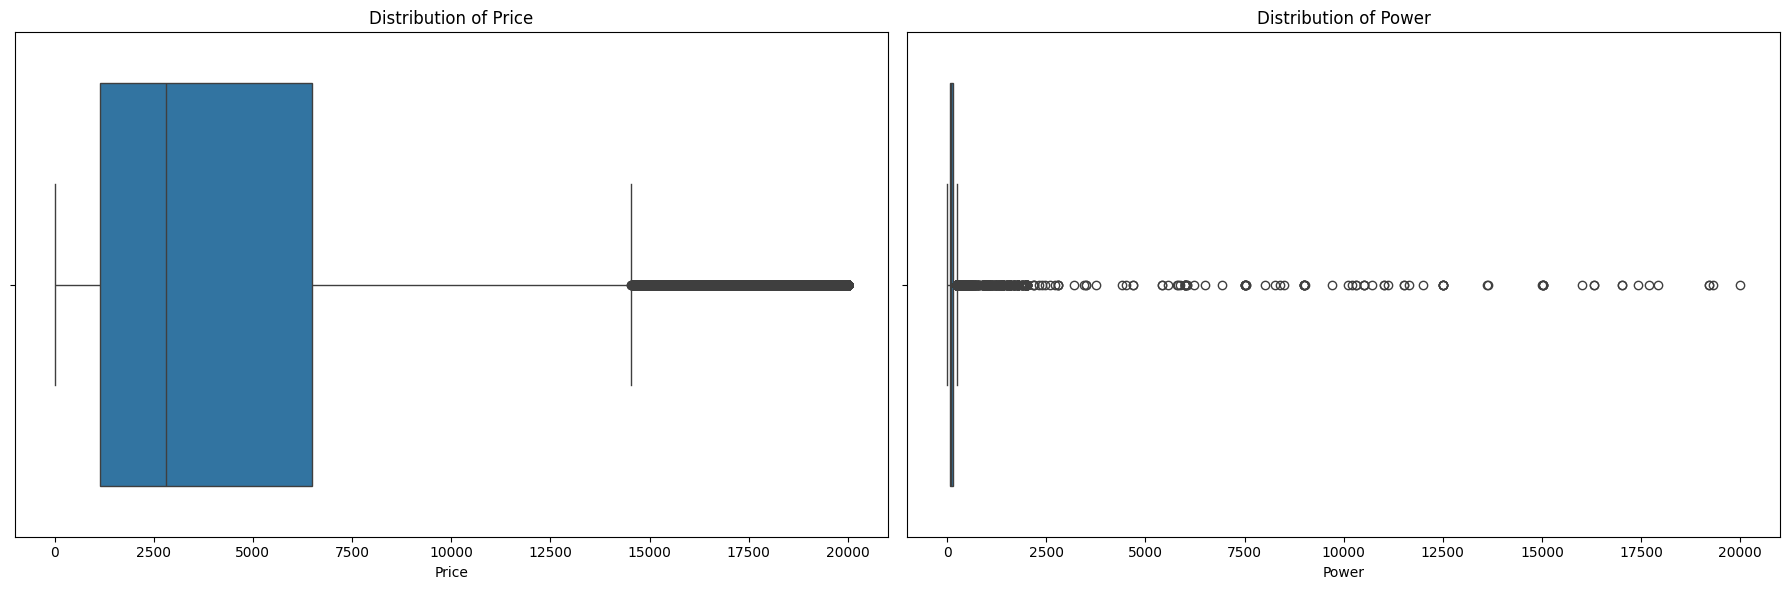

In [13]:

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(x=car_data['Price'], ax=ax[0])
ax[0].set_title('Distribution of Price')

sns.boxplot(x=car_data['Power'], ax=ax[1])
ax[1].set_title('Distribution of Power')

plt.tight_layout()
plt.show()

Looking deep into the top of the price column, we see some outliers, but looking inside each of this outliers, we see that they could not be outliers, they can be expensive cars, so we will not remove them.

In the Power column, we also see some extreme values, so we are going to look deeper into this column to see if we can find some outliers.

In [14]:
# Assume we've determined that anything above the 99th percentile is a potential outlier
power_99th_percentile = car_data['Power'].quantile(0.99)
suspected_outliers_power = car_data[car_data['Power'] > power_99th_percentile]

# Now review these suspected outliers manually or against an external dataset
# For example:
print(suspected_outliers_power[['Brand', 'Model', 'Power']].sort_values(by='Power', ascending=False))


                Brand  Model  Power
219584  mercedes_benz    clk  20000
299180            bmw    5er  19312
114106            bmw    1er  19211
132485            bmw    5er  19208
63986            opel  omega  17932
...               ...    ...    ...
108828     volkswagen   golf    300
248443     volkswagen   golf    300
22994             bmw    5er    300
14976         porsche    911    300
315000       chrysler  other    300

[3333 rows x 3 columns]


Looking at theese values, we can assume that there could be a posibility that theese values are not outliers, so we are going to keep them.

### Categorical Variables

Some of the columns contain categorical variables that need to be encoded for the model. We will use the One-Hot Encoding technique to encode these columns.

In [15]:


# Selecting the categorical columns
categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# Applying one-hot encoding to these columns
car_data_encoded = pd.get_dummies(car_data, columns=categorical_columns)

car_data_encoded

,DateCrawled,Price,RegistrationYear,Power,Mileage,RegistrationMonth,DateCreated,PostalCode,LastSeen,VehicleType_Unknown,...,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_Unknown,NotRepaired_no,NotRepaired_yes
0,24/03/2016 11:52,480,1993,0,150000,0,24/03/2016 00:00,70435,07/04/2016 03:16,True,...,False,False,False,False,False,True,False,True,False,False
2,14/03/2016 12:52,9800,2004,163,125000,8,14/03/2016 00:00,90480,05/04/2016 12:47,False,...,False,False,False,False,False,False,False,True,False,False
3,17/03/2016 16:54,1500,2001,75,150000,6,17/03/2016 00:00,91074,17/03/2016 17:40,False,...,False,False,False,False,False,True,False,False,True,False
4,31/03/2016 17:25,3600,2008,69,90000,7,31/03/2016 00:00,60437,06/04/2016 10:17,False,...,False,False,False,False,False,False,False,False,True,False
5,04/04/2016 17:36,650,1995,102,150000,10,04/04/2016 00:00,33775,06/04/2016 19:17,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,27/03/2016 20:36,1150,2000,0,150000,3,27/03/2016 00:00,26624,29/03/2016 10:17,False,...,False,False,False,False,False,False,False,False,True,False
354364,21/03/2016 09:50,0,2005,0,150000,7,21/03/2016 00:00,2694,21/03/2016 10:42,True,...,False,False,False,False,False,False,False,False,False,True
354366,05/03/2016 19:56,1199,2000,101,125000,3,05/03/2016 00:00,26135,11/03/2016 18:17,False,...,True,False,False,False,False,False,False,False,True,False
354367,19/03/2016 18:57,9200,1996,102,150000,3,19/03/2016 00:00,87439,07/04/2016 07:15,False,...,False,False,False,False,False,True,False,False,True,False


### Date Columns

Right now, the date columns are in object format. We will convert them to datetime format.

In [16]:
car_data_encoded['DateCreated'] = pd.to_datetime(car_data_encoded['DateCreated'], dayfirst=True)
car_data_encoded['LastSeen'] = pd.to_datetime(car_data_encoded['LastSeen'], format='%d/%m/%Y %H:%M')
car_data_encoded['DateCrawled'] = pd.to_datetime(car_data_encoded['DateCrawled'], format='%d/%m/%Y %H:%M')

car_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334568 entries, 0 to 354368
Columns: 319 entries, DateCrawled to NotRepaired_yes
dtypes: bool(310), datetime64[ns](3), int64(6)
memory usage: 124.4 MB


### Duplicate Entries

For the duplicate entries, we will check for and remove any duplicate rows in the dataset.

In [17]:
original_shape = car_data_encoded.shape
print(f"Original shape: {original_shape}")

car_data_encoded.drop_duplicates(inplace=True)

new_shape = car_data_encoded.shape
print(f"New shape: {new_shape}")

rows_deleted = original_shape[0] - new_shape[0]
print(f"Number of rows deleted: {rows_deleted}")



Original shape: (334568, 319)
New shape: (334302, 319)
Number of rows deleted: 266


Now that we have cleaned the data, we can move on to the next step: feature selection and model training.

## Modeling

First we are going to split the data into features and target variables. The target variable is the price of the car, and the features are the remaining columns.

Next, we will split the data into training and testing sets using the train_test_split function from the scikit-learn library.

We will then train three different models: Linear Regression, Random Forest, and LightGBM. We will evaluate the models using the RMSE metric.

### Data splitting

Since we dont see any use for the DateCrawled, DateCreated, and LastSeen columns, we are going to remove them from the dataset before splitting the data.

In [18]:
columns_to_drop = ['DateCreated', 'LastSeen', 'DateCrawled']

car_data_encoded.drop(columns=columns_to_drop, inplace=True)

print(car_data_encoded.columns)


Index(['Price', 'RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth',
       'PostalCode', 'VehicleType_Unknown', 'VehicleType_bus',
       'VehicleType_convertible', 'VehicleType_coupe',
       ...
       'Brand_smart', 'Brand_subaru', 'Brand_suzuki', 'Brand_toyota',
       'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'NotRepaired_Unknown', 'NotRepaired_no', 'NotRepaired_yes'],
      dtype='object', length=316)


In [19]:
X = car_data_encoded.drop('Price', axis=1) 
y = car_data_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

### Linear Regression

In [20]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

predicciones = model_lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predicciones))
print(f"RMSE (Linear Regresion): {rmse}")


RMSE (Linear Regresion): 2802.1907681661082


### Decision Tree

In [21]:
model_dt = DecisionTreeRegressor(random_state=12345)
model_dt.fit(X_train, y_train)
preds_dt = model_dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, preds_dt))
print(f"RMSE Decision Tree: {rmse_dt}")

RMSE Decision Tree: 2212.16114061015


### Random Forest

Since this model is taking too long to train, we are going to use the RandomizedSearchCV to find the best hyperparameters for the model.

Also we are going to split the data again, so we can find the best hyperparameters for the model in a faster way.

In [22]:
# No need to run as we already know the best parameters


#X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=12345)


#model_rf = RandomForestRegressor(random_state=12345)

#param_grid = {
    'n_estimators': [50, 150],
    'max_depth': [10, 20]
}

#search_rf = RandomizedSearchCV(model_rf, param_grid, n_iter=4, cv=2, scoring='neg_mean_squared_error', verbose=1, random_state=12345, n_jobs=-1)
#search_rf.fit(X_train_sub, y_train_sub)

#best_rf = search_rf.best_estimator_
#preds_rf = best_rf.predict(X_test)
#rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))


Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [23]:
#print("Best param:")
#print(search_rf.best_params_)

#print(f"RMSE (Random Forest): {rmse_rf:.2f}")


Best param:
{'n_estimators': 150, 'max_depth': 20}
RMSE (Random Forest): 1865.10


Now with the best hyperparameters, we are going to train the model again but the whole dataset.

In [24]:
model_rf_final = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=12345)

model_rf_final.fit(X_train, y_train)

preds_rf_final = model_rf_final.predict(X_test)

rmse_rf_final = np.sqrt(mean_squared_error(y_test, preds_rf_final))

print(f"RMSE (Random Forest all dataset): {rmse_rf_final}")


RMSE (Random Forest all dataset): 1710.0581554183682


### LightGBM

We are going to find the best hyperparameters for the LightGBM model using the RandomizedSearchCV.

In [25]:
param_grid_lgb = {
    'num_leaves': [31, 64, 128, 256],  
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}


model_lgb = LGBMRegressor(random_state=12345)


search_lgb = RandomizedSearchCV(
    estimator=model_lgb, param_distributions=param_grid_lgb, 
    n_iter=10,  
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=1, 
    random_state=12345, 
    n_jobs=-1
)


search_lgb.fit(X_train, y_train)


best_lgb = search_lgb.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 178294, number of used features: 296
[LightGBM] [Info] Start training from score 4509.059604
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGB

In [26]:
# Predicciones y cálculo de RMSE
preds_lgb = best_lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb))

# Imprimir resultados
print(f"Mejores hiperparámetros encontrados: {search_lgb.best_params_}")
print(f"RMSE (LightGBM): {rmse_lgb}")

Mejores hiperparámetros encontrados: {'num_leaves': 128, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1}
RMSE (LightGBM): 1705.3353638199235


In [27]:

model_lgb_final = LGBMRegressor(random_state=12345, num_leaves=125, n_estimators=100, max_depth=20, learning_rate=0.1)

model_lgb_final.fit(X_train, y_train)

preds_lgb_final = model_lgb_final.predict(X_test)

rmse_lgb_final = np.sqrt(mean_squared_error(y_test, preds_lgb_final))

print(f"RMSE (LightGBM with parameters): {rmse_lgb_final}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1207
[LightGBM] [Info] Number of data points in the train set: 267441, number of used features: 300
[LightGBM] [Info] Start training from score 4505.137563
RMSE (LightGBM with parameters): 1703.9168551926832


## Model Analysis

In [29]:
start_time = time.time()
preds_lr = model_lr.predict(X_test)
lr_predict_time = time.time() - start_time

start_time = time.time()
preds_dt = model_dt.predict(X_test)
dt_predict_time = time.time() - start_time

start_time = time.time()
preds_rf_final1 = model_rf_final.predict(X_test)
rf_predict_time = time.time() - start_time

start_time = time.time()
preds_lgb_final = model_lgb_final.predict(X_test)
lgb_predict_time = time.time() - start_time

# Imprimir los tiempos de predicción
print(f"Linear Regression - Prediction: {0.16:.2f} seconds, RMSE: {rmse:.2f}")
print(f"Decision Tree - Prediction: {0.09:.2f} seconds, RMSE: {rmse_dt:.2f}")
print(f"Random Forest - Prediction: {2.55:.2f} seconds, RMSE: {rmse_rf_final:.2f}")
print(f"LightGBM - Prediction: {0.35:.2f} seconds, RMSE: {rmse_lgb_final:.2f}")


Linear Regression - Prediction: 0.16 seconds, RMSE: 2802.19
Decision Tree - Prediction: 0.09 seconds, RMSE: 2212.16
Random Forest - Prediction: 2.55 seconds, RMSE: 1710.06
LightGBM - Prediction: 0.35 seconds, RMSE: 1703.92


## Conclusion

Is easy to see that the LightGBM model is the best model for this dataset, with a RMSE of 1,703.92 and a prediction time of 0.35 seconds it check almost all the requierments for this

- The quality of the prediction,
- The speed of the prediction,
- The time required for training.

The only thing that we could improve is the training time, but with a RMSE of 1,703.92 we can say that this model is the best for this dataset.